# Test up/downsample 1d blocks

In [1]:
import torch
import torch.nn.functional as F
from torch import nn
from models.upsampling import upsample_1d
from models.downsampling import downsample_1d
import matplotlib.pyplot as plt

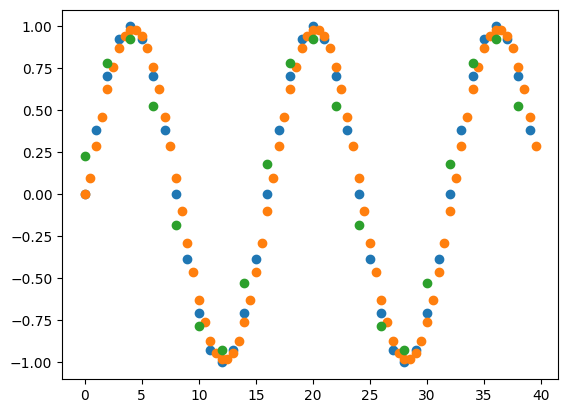

In [2]:
t = torch.arange(40)
t_up = torch.arange(80)/2
t_down = torch.arange(20)*2
hidden_states = torch.sin(2*torch.pi*t/16).unsqueeze(0).unsqueeze(1)
kernel = (1, 3, 3, 1)
hidden_states_up = upsample_1d(hidden_states, kernel, factor = 2)
hidden_states_down = downsample_1d(hidden_states, kernel, factor = 2)

plt.scatter(t, hidden_states.squeeze())
plt.scatter(t_up, hidden_states_up.squeeze())
plt.scatter(t_down, hidden_states_down.squeeze())

# Test UNet1DConditionModel forward pass

In [3]:
from models.unet.unet_1d_condition import UNet1DConditionModel
from diffusers import DPMSolverMultistepScheduler

In [4]:
unet_1d = UNet1DConditionModel(
    sample_size=1024,  # the target signal len
    in_channels=1,
    out_channels=2,
    layers_per_block=2,  # how many ResNet layers to use per UNet block
    block_out_channels=(64, 64, 64, 128, 256),  # the number of output channels for each UNet block
    down_block_types=(
        "DownBlock1D",
        "AttnDownBlock1D", 
        "SimpleCrossAttnDownBlock1D",
        "CrossAttnDownBlock1D",
        "ResnetDownsampleBlock1D",
    ),
    mid_block_type="UNetMidBlock1DCrossAttn",
    up_block_types=(
        "ResnetUpsampleBlock1D",
        "CrossAttnUpBlock1D",
        "SimpleCrossAttnUpBlock1D",
        "AttnUpBlock1D", 
        "UpBlock1D",
    ),
    num_class_embeds=11,
    class_embeddings_concat=True,
    encoder_hid_dim=64
)

noise_scheduler = DPMSolverMultistepScheduler(
    num_train_timesteps=1000,
    prediction_type='epsilon',
)

In [5]:
sample_seq, sample_label = torch.randn(4, 1, 480), torch.tensor([1,2,3,4]).long()
print("Input shape:", sample_seq.shape)
print("Input max/min:", (sample_seq.max(), sample_seq.min()))

with torch.no_grad():
    noise = torch.randn(sample_seq.shape)
    target_noise = torch.randn(sample_seq.repeat(1, 2, 1).shape)
    timesteps = torch.LongTensor([5])
    noisy_seq = noise_scheduler.add_noise(sample_seq, noise, timesteps)
    dummy_seq_cond = torch.zeros([4, 1, 64])
    noise_pred = unet_1d(sample_seq, timestep=0, encoder_hidden_states=dummy_seq_cond, class_labels=sample_label).sample
    print("Output shape:", noise_pred.shape)
    loss = F.mse_loss(noise_pred, target_noise)

print("loss:", loss)

Input shape: torch.Size([4, 1, 480])
Input max/min: (tensor(2.9811), tensor(-3.1412))
Output shape: torch.Size([4, 2, 480])
loss: tensor(1.1210)
